In [1]:
from IPython.display import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(random_state=1))
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression(random_state=1))])

# 6.3 학습 곡선과 검증 곡선을 사용한 알고리즘 디버깅

### 6.3.1 학습 곡선으로 편향과 분산 문제 분석
주어진 훈련 데이터셋에 비해 모델이 너무 복잡하면(모델의 자유도나 모델 파라미터가 너무 많으면) 모델이 훈련 데이터에 과대적합되고, 새로운 데이터에 잘 일반화되지 못하는 경향이 있다. 보통 훈련 샘플을 더 모으면 과대적합을 줄이는 데 도움이 되지만, 그러지 못하는 경우가 있다.

모델의 훈련 정확도와 검증 정확도를 훈련 데이터셋의 크기 함수로 그래프로 그려보면 모델의 높은 분산의 문제인지 높은 편향의 문제인지 알 수 있다. 

In [2]:
# 편향-분산 트레이드 오프
Image(url='https://git.io/JtsTi', width=600) 

* 높은 편향(왼쪽 위 그래프) : 훈련 정확도와 교차 검증 정확도가 모두 낮다. 
    * 훈련 데이터에 과소적합.
    * 해결방안
        * 모델의 파라미터 개수를 늘린다. 추가적인 특성을 수집하거나 만든다.
        * 서포트 벡터 머신(SVM)이나 로지스틱 회귀 분류기에에서 규제 강도를 줄인다.
* 높은 분산(오른쪽 위 그래프) : 훈련 정확도와 교차 검증 정확도 사이에 큰 차이가 있다.
    * 훈련 데이터에 과대적합
    * 해결방안
        * 더 많은 훈련 데이터를 모은다. - 항상 도움되는 것은 아니다 => 훈련 데이터에 잡음이 아주 많거나 몯레이 이미 거의 최적화 된 겅우
        * 모델 복잡도를 낮추거나 규제를 증가.
        * 규제가 없는 모델의 경우, 특성 선택 또는 특성 추출을 통해 특성 개수를 줄인다.


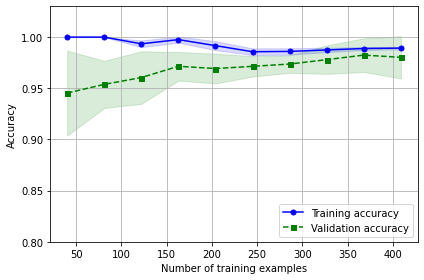

In [3]:
# 검증 곡선
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=1, max_iter=10000))
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, 
                                                        X=X_train, y=y_train, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), 
                                                        cv=10, n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

LogisticRegression 클래스 객체를 만들 때 max_iter=10000 매개변수(default=1000) 값을 전달한다. 큰 규제 매개변수 값이나 작은 데이터셋 크기에 발생할 수 있는 수렴 문제를 피하기 위해서이다.

learning_curve 함수의 train_sizes 매개변수를 통해 학습 곡선을 생성하는 데 사용할 훈련 샘플의 개수나 비율을 지정할 수 있다.

train_sizes=np.linspace(0.1, 1.0, 10)을 지정하여 일정한 간격으로 훈련 데이터셋의 비율 열 개를 설정했다. 기본적으로 learning_curve 함수는 계층별 k-겹 교차 검증을 사용하여 분류기의 교차 검증 정확도를 계산한다. cv 매개변수를 통해 k 값을 10으로 지정했기 때문에 계층별 10-겹 교차 검증을 사용한다.

반환된 훈련과 테스트 교차 검증 점수로부터 훈련 데이터셋 크기별로 평균 정확도를 계산하여 맷플롯립의 plot 함수를 사용해서 그래프를 그린다. fill_between 함수를 사용하여 그래프에 평균 정확도의 표준 편차를 그려 추정 분산을 나타낸다.

학습 곡선 그래프에서 볼 수 있듯이 모델 훈련에 250개의 샘플 이상을 사용할 때 훈련과 검증 데이터셋에서 잘 작동한다. 훈련 데이터셋이 250개의 샘플보다 줄어들면 훈련 정확도가 증가하면서 훈련 정확도와 검증 정확도 사이의 차이는 넓어진다. 이는 과대적합이 증가한다는 증거이다.

### 6.3.2 검증 곡선으로 과대적합과 과소적합 조사
* 검증 곡선 : 과대적합과 과소적합 문제를 해결하여 모델 성능을 높일 수 있는 유용한 도구
    * 학습 곡선과 관련 있지만 샘플 크기의 함수로 훈련 정확도와 테스트 정확도를 그리는 대신 모델 파라미터 값의 함수로 그린다.

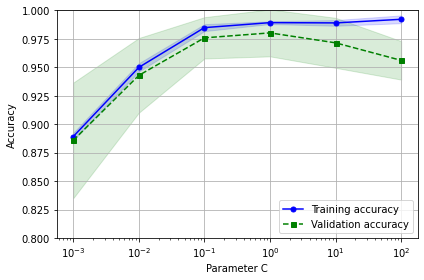

In [4]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr, 
                                            X=X_train, y=y_train, 
                                            param_name='logisticregression__C', 
                                            param_range=param_range,
                                            cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

* 매개변수 C에 대한 검증 곡선 그래프 - validation_curve
    * 기본적으로 계층별 k-겹 교차 검증을 사용하여 모델의 성능을 추정
    * validation_curve 함수 안에서 평가하기 위한 매개변수를 지정
    * 예를 들어, 사이킷런 파이프라인 안에 있는 LogisticRegression 객체의 매개변수를 지정하려면 'logisticregression__C' 처럼 쓴다.
    * param_range 매개변수에는 값 번위 지정.

C 값이 바뀜에 따라 정확도 차이가 미묘하지만 규제 강도를 높이면(C 값을 줄이면) 모델이 데이터에 조금 과소적합되는 것을 볼 수 있다. 규제 강도가 낮아지는 C 값에서는 모델이 데이터에 조금 과대적합되는 경향을 보인다. 위 경우 적절한 C 값은 0.01과 0.1 사이이다.

# 6.4 그리드 서치를 사용한 머신 러닝 모델 세부 튜닝
* 머신러닝 파라미터
    * 훈련 데이터에서 학습되는 파라미터
        * ex) 로지스틱 회귀의 가중치
    * 별도로 최적화되는 학습 알고리즘의 파라미터
        * 모델의 튜닝 파라미터 - 하이퍼파라미터
        * ex) 로지스틱 회귀의 매개변수나 결정 트리의 깊이 매개변수

* 그리드 서치 : 하이퍼파라미터 최적화 기법
    * 하이퍼파라미터 값에 대한 최적의 조합을 찾음으로써 모델 성능을 향상시킨다.

### 6.4.1 그리드 서치를 사용한 하이퍼파라미터 튜닝
* 리스트로 지정된 여러 가지 하이퍼파라미터 값 전체를 모두 조사.
    * 이 리스트에 있는 값의 모든 조합에 대해 모델 성능을 평가하여 최적의 조합을 찾는다.

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C':param_range, 'svc__kernel':['linear']},
              {'svc__C':param_range, 'svc__gamma':param_range, 'svc__kernel':['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', refit=True, cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


GridSearchCV 클래스의 객체를 만들고 서포트 벡터 머신(SVM)을 위한 파이프라인을 훈련하고 튜닝한다. GridSearchCV 클래스의 param_grid에 튜닝하려는 매개변수를 딕셔너리의 리스트로 지정. 선형 SVM의 경우 규제 매개변수 C만 튜닝한다. BRF 커널 SVM 에서는 svc__C와 svc__gamma 매개변수를 튜닝. svc__gamma 매개변수는 커널 SVM 에만 해당한다.

훈련 데이터셋을 사용하여 그리드 서치를 수행한 후 최상의 모델 점수는 best_scores_ 속성에서 얻고 이 모델의 매개변수는 best_params_ 속성에서 확인할 수 있다.

독집적인 테스트 데이터셋을 사용하여 최고 모델의 성능 추정한다. 이 모델은 GridSearchCV 객체의 best_estimator_ 속성에서 얻을 수 있다.

In [6]:
clf = gs.best_estimator_

# refit=True로 지정했기 때문에 다시 fit() 메서드를 호출할 필요가 없습니다.
# clf.fit(X_train, y_train)

print('테스트 정확도: %.3f' % clf.score(X_test, y_test))

테스트 정확도: 0.974


`GridSearchCV` 클래스와 `cross_validate` 함수에서 `return_train_score` 매개변수를 True로 지정하면 훈련 폴드에 대한 점수를 계산하여 반환한다. 훈련 데이터셋에 대한 점수를 보고 과대적합과 과소적합에 대한 정보를 얻을 수 있지만 실행 시간이 오래걸릴 수 있다.

param_range에 8개의 값이 지정되어 있기 때문에 SVC 모델은 'linear' 커널에 대해 8번, 'rbf' 커널에 대해 64번의 교차 검증이 수행된다. 따라서 훈련 폴드마다 반환되는 점수는 총 72개이다. 이 값은 GridSearchCV 클래스의 cv_results_ 딕셔너리 속성에 split{폴드번호}_train_score와 같은 키에 저장되어 있다. 예를 들어 첫 번째 폴드의 점수는 'split0_train_score' 키로 저장되어 있다.

In [7]:
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  return_train_score=True,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
gs.cv_results_['split0_train_score']

array([0.6405868 , 0.93643032, 0.97555012, 0.98777506, 0.98533007,
       0.99266504, 0.99755501, 1.        , 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.7799511 , 0.94621027,
       0.96577017, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.78484108, 0.94621027, 0.9804401 , 0.99266504, 1.        ,
       1.        , 1.        , 1.        , 0.94621027, 0.97799511,
       0.99266504, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.97799511, 0.98777506, 0.99511002, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.98533007,
       0.99266504, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

전체 훈련 점수의 평균 값은 `mean_train_score` 키에 저장되어 있다.

In [8]:
gs.cv_results_['mean_train_score']

array([0.6402928 , 0.93724074, 0.97240801, 0.98510406, 0.98803447,
       0.99145447, 0.99707019, 0.9992677 , 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.77070249, 0.94700817,
       0.97167094, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.77949371, 0.94725326, 0.97704753, 0.99291848, 1.        ,
       1.        , 1.        , 1.        , 0.94652096, 0.97753354,
       0.99023257, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.97680064, 0.98852287, 0.99755799, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.98803387,
       0.99291848, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

비슷하게 첫 번째 폴드에 대한 테스트 점수는 `split0_test_score` 키에 저장되어 있다.

In [9]:
gs.cv_results_['split0_test_score']

array([0.63043478, 0.89130435, 0.95652174, 0.97826087, 0.95652174,
       0.93478261, 0.95652174, 0.93478261, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.69565217, 0.93478261,
       0.95652174, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.69565217, 0.93478261, 0.93478261, 1.        , 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.93478261, 0.97826087,
       1.        , 1.        , 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.97826087, 0.97826087, 0.97826087, 1.        ,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.97826087,
       0.95652174, 0.95652174, 1.        , 0.63043478, 0.63043478,
       0.63043478, 0.63043478])

`GridSearchCV` 클래스의 객체에서도 최종 모델의 `score`, `predict`, `transform` 메서드를 바로 호출할 수 있다.

In [10]:
print('테스트 정확도: %.3f' % gs.score(X_test, y_test))

테스트 정확도: 0.974


#### 랜덤한 하이퍼파라미터 탐색
* 그리드 서치의 경우 최적의 매개변수 조합을 찾을 수 있는 좋은 도구이지만 가능한 모든 매개변수 조합을 평가하기 위해 계산 비용이 매우 많이 든다.
* 여러 가지 매개변수 조합을 샘플링하는 다른 방법으로 랜덤 서치가 있다.
* 랜덤 서치
    * 그리드 서치와 비슷한 성능을 내지만 훨씬 비용과 시간이 적게 든다.
    * 특히 랜덤 서치에서 60개의 파라미터 조합이 있다면 최적의 성능 5% 이내에 있는 솔루션을 얻을 확률이 95%이다.
    * RandomizedSearchCV 클래스를 사용하여 제한된 횟수 안에서 샘플링 분포로부터 랜덤한 매개변수 조합을 뽑는다.

매개변수 탐색 범위가 넓거나 규제 매개변수 C 처럼 연속적인 값을 탐색해야 하는 경우에 RandomizedSearchCV가 더 효율적이다. n_iter 매개변수로 탐색 횟수를 조정할 수 있어 컴퓨팅 자원에 맞게 탐색을 실행할 수 있다. RandomizedSearchCV에는 샘플링 가능한 분포를 지정해야 한다.

* 샘플링 가능한 분포
    * `scipy.stats.uniform`
    * `scipy.stats.randint`
    * `scipy.stats.reciprocal` : 로그 균등 분포(log-uniform distribution) 클래스 `loguniform`을 제공


In [11]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

distribution = loguniform(0.0001, 1000.0)

param_dist = [{'svc__C': distribution, 'svc__kernel':['linear']},
              {'svc__C': distribution, 'svc__gamma': distribution, 'svc__kernel': ['rbf']}]
rs = RandomizedSearchCV(estimator=pipe_svc, param_distributions=param_dist,
                        n_iter=30, cv=10, random_state=1, n_jobs=-1)
rs = rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)

0.9824637681159419
{'svc__C': 210.6644070836221, 'svc__gamma': 0.0006861724481510375, 'svc__kernel': 'rbf'}


`RandomizedSearchCV`의 탐색 횟수는 절반 이상 적지만 더 좋은 성능을 내는 매개변수 조합을 찾아냈다.

* 사이킷런의 HalvingGridSearchCV
    * 모든 파라미터 조합에 대해 제한된 자원으로 실행한 후 가장 좋은 후보를 골라 더 많은 자원을 투여하며 반복적으로 탐색을 수행
    * SH(Successive Halving)
    * 매개변수
        * `resource` : 반복마다 늘려갈 자원을 정의. default=`n_samples` 샘플 개수
            * 이 외 : 탐색 대상 모델에서 양의 정수 값을 가진 매개변수를 지정. ex) 랜덤 포레스트의 n_estimators
        * `min_resources` : 첫 번째 반복에서 각 후보가 사용할 최소 자원을 지정
            * `resources='n_samples'` 이고 `min_resources='smallest'`이면 회귀일 때 `cv` X 2가 되고 분류일때는 `cv` X 클래스개수 X 2가 된다.
                * 이 외에는 1이다.
            * `min_resources='exhaust'`이면 앞에서 계산한 값과 `max_resources`를 `factor`**`n_required_iterations`으로 나눈 몫 중 큰 값이다.
            * default='exhaust'
            * `n_required_iterations`는 $log_{factor}(전체후보개수)+1$이다
        * `aggressive_elimination` : True -> 마지막 반복에서 `factor` 만큼 후보가 남을 수 있도록 자원을 늘리지 않고 초기에 반복을 여러 번 진행한다.
            * default=False

`HalvingGridsearchCV`는 아직 실험적이기 때문에 `sklearn.experimental` 패키지 아래에 있는 `enable_halving_search_cv`을 임포트 해야 사용할 수 있다. `verbose=1`로 지정하면 각 과정을 자세히 볼 수 있다.

In [12]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

hgs = HalvingGridSearchCV(estimator=pipe_svc,
                          param_grid=param_grid,
                          cv=10,
                          n_jobs=-1, verbose=1)
hgs = hgs.fit(X_train, y_train)
print(hgs.best_score_)
print(hgs.best_params_)

n_iterations: 3
n_required_iterations: 4
n_possible_iterations: 3
min_resources_: 40
max_resources_: 455
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 72
n_resources: 40
Fitting 10 folds for each of 72 candidates, totalling 720 fits
----------
iter: 1
n_candidates: 24
n_resources: 120
Fitting 10 folds for each of 24 candidates, totalling 240 fits
----------
iter: 2
n_candidates: 8
n_resources: 360
Fitting 10 folds for each of 8 candidates, totalling 80 fits
0.9775396825396825
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


* 첫 번째 반복(iter=0) : 72개의 후보를 40개의 샘플로 교차 검증을 수행. 72/3=24개의 후보를 뽑는다.
* 두 번째 반복(iter=1) : 40 * 3 = 120개의 샘플을 사용한다.
* 세 번째 반복(iter=2) : 8개의 후보가 360개의 샘플로 평가한다.
* 최종 결과 : 98.5%
* 세 번의 반복동안 HalvingGridSearchCV가 수행한 교차 검증 횟수는 모두 104번이다.
* 각 교차 검증에 걸린 시간은 cv_results_ 속성의 mean_fit_time에 저장되어 있다.
* GridSearchCV와 비교해 5배 이상 빠르다.

In [13]:
print(np.sum(hgs.cv_results_['mean_fit_time']))

0.4161378383636475


각 반복 단계에서 사용한 샘플 개수와 후보 개수는 각각 n_resources_ 속성과 n_candidates_ 속성에 저장되어 있다.

In [14]:
print('자원 리스트:', hgs.n_resources_)
print('후보 리스트:', hgs.n_candidates_)

자원 리스트: [40, 120, 360]
후보 리스트: [72, 24, 8]


### 6.4.2 중첩 교차 검증을 사용한 알고리즘 선택
* 중첩 교차 검증(nested cross-validation) : 여러 종류의 머신러닝 알고리즘 비교
    * 바깥쪽 k-겹 교차 검증 루프가 데이터를 훈련 폴드와 테스트 폴드로 나누고 안쪽 루프가 훈련 폴드에서 k-겹 교차 검증을 수행하여 모델 선택.
    * 계산 성능이 중요한 대용량 데이터셋에 유용
    * 중첩 교차 검증의 폴드 개수를 고려하여 5 * 2 교차 검증이라고도 한다.

In [15]:
from sklearn.model_selection import cross_val_score

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid,
                  scoring='accuracy', cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV 정확도 : %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV 정확도 : 0.974 +/- 0.015


반환된 평균 교차 검증 점수는 모델의 하이퍼파라미터를 튜닝했을 때 처음 본 데이터에서 기대할 수 있는 추정 값이 된다. 예를 들어 중첩 교차 검증을 사용하여  SVM 모델과 단일 결정 트리 분류기를 비교할 수 있다. 

In [16]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth':[1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy', cv=2)

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV 정확도: 0.934 +/- 0.016
